# Convolutional autoencoder for image denoising
[See Supplementary Table 3~5 for Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.models import Model
from keras.callbacks import LearningRateScheduler


# def preprocess(array):
#     """Normalizes the supplied array and reshapes it."""
#     array = array.astype("float32") / 255.0
#     array = np.reshape(array, (len(array), 800, 1))
#     return array


def noise(array, noise_factor = 0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2, n = 4):
    """Displays <n> random signals from each array."""
    indices = np.random.randint(len(array1), size=n)
    signals1 = array1[indices, :]
    signals2 = array2[indices, :]

    plt.figure(figsize=(20, n))
    for i, (signal1, signal2) in enumerate(zip(signals1, signals2)):
        # Original signal
        ax = plt.subplot(2, n, i + 1)
        plt.plot(signal1)
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Noisy signal
        ax = plt.subplot(2, n, i + 1 + n)
        plt.plot(signal2)
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

In [2]:
# Path to .npz files
train_npz_path = "../data/train.npz"
test_npz_path = "../data/test.npz"

# Load data
train_npz = np.load(train_npz_path)
test_npz = np.load(test_npz_path)

train_data = train_npz["signal"]
test_data = test_npz["signal"]

print(train_data.shape)
print(test_data.shape)

(2803934, 800, 1)
(17617, 800, 1)


In [3]:
# For demonstration purpose only, we will only be using a subset of the dataset
train_size = 1000
test_size = 100

train_indices = np.random.choice(train_data.shape[0], size=train_size, replace=False)
test_indices = np.random.choice(test_data.shape[0], size=test_size, replace=False)

train_data = train_data[train_indices]
test_data = test_data[test_indices]

print("Train data subset shape:", train_data.shape)
print("Test data subset shape:", test_data.shape)


Train data subset shape: (1000, 800, 1)
Test data subset shape: (100, 800, 1)


Noise Factor: 0.001


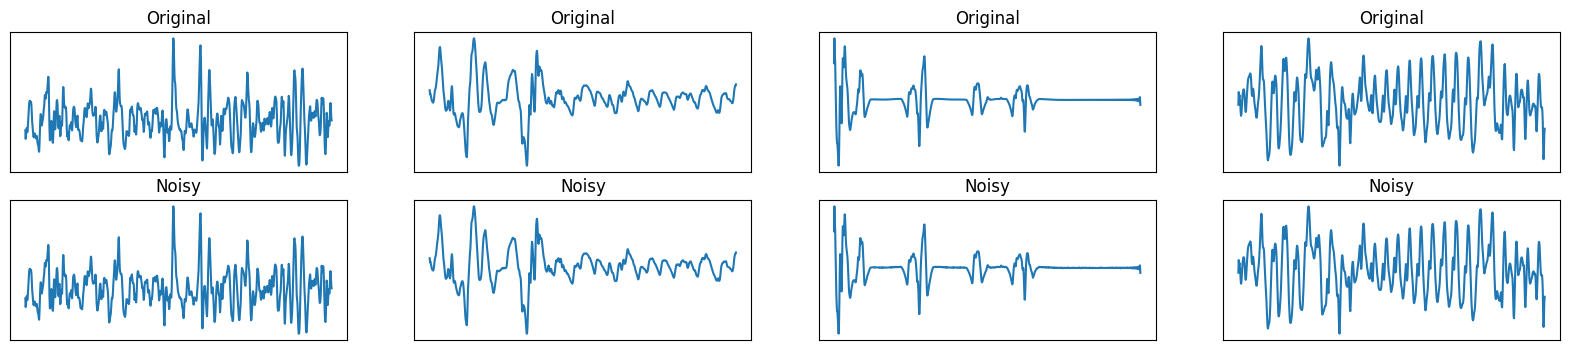

Noise Factor: 0.25


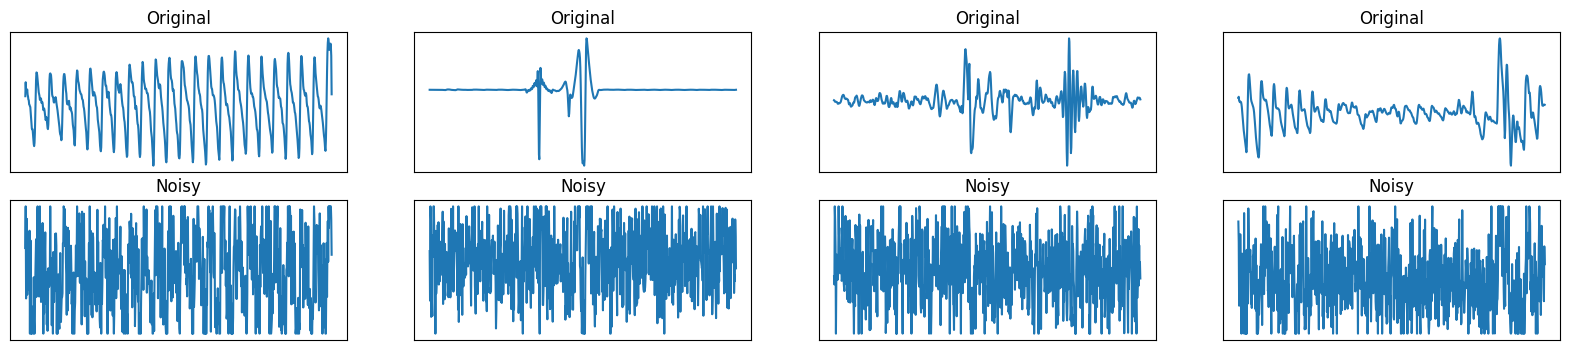

Noise Factor: 0.5


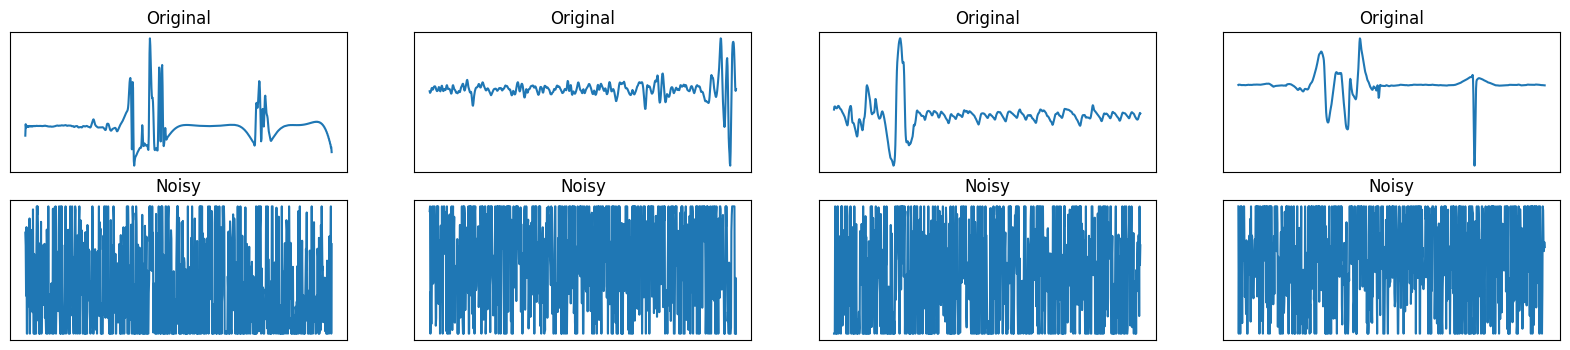

Noise Factor: 0.75


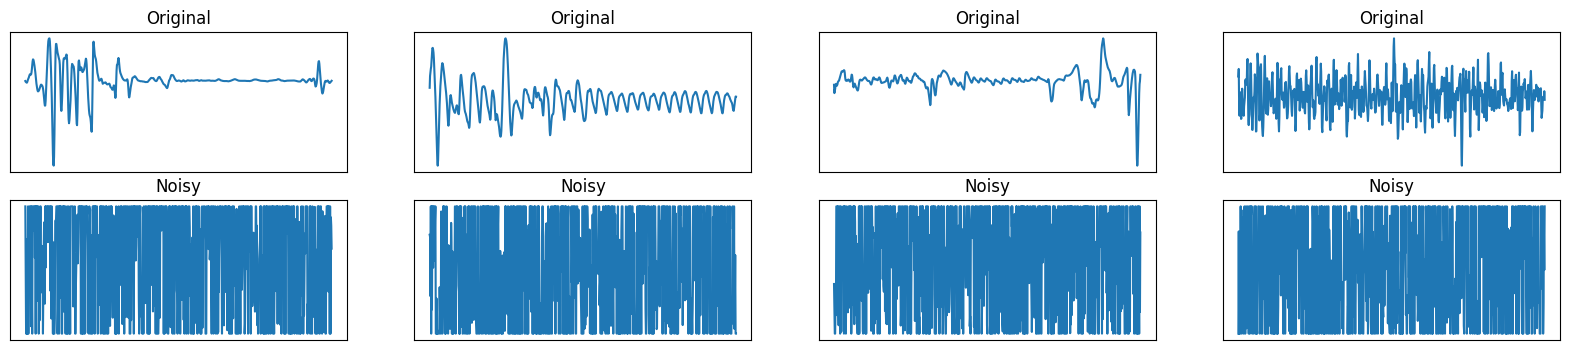

Noise Factor: 1


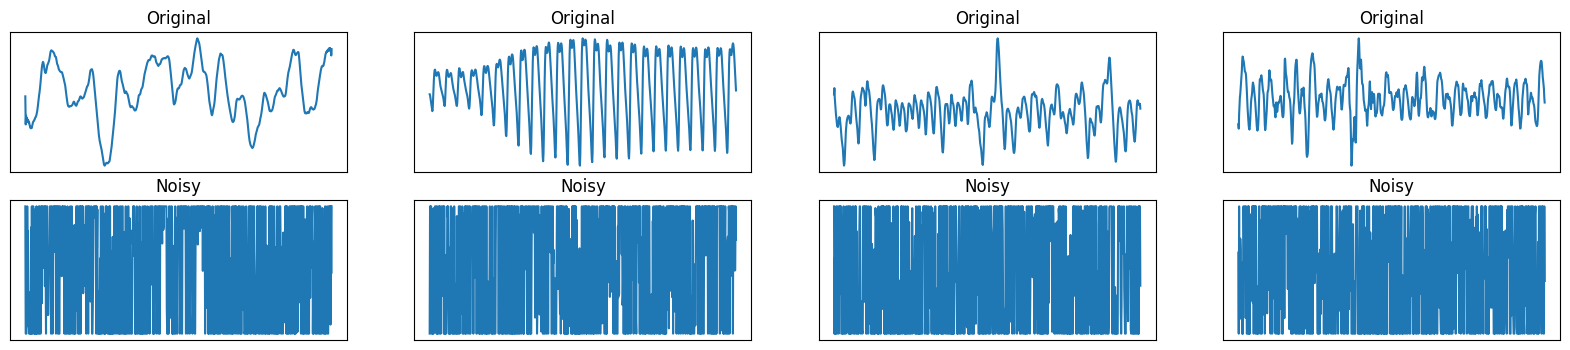

Noise Factor: 2


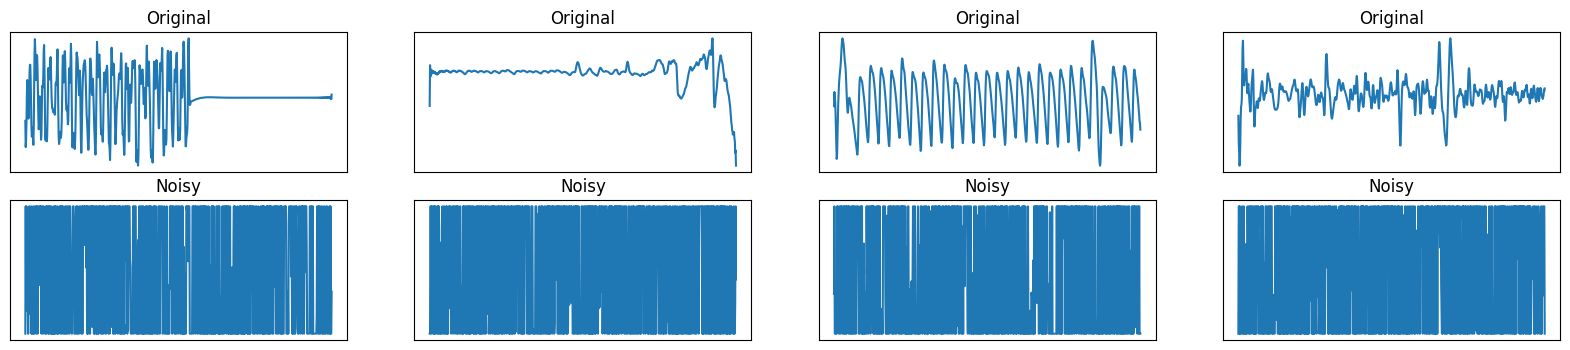

Noise Factor: 5


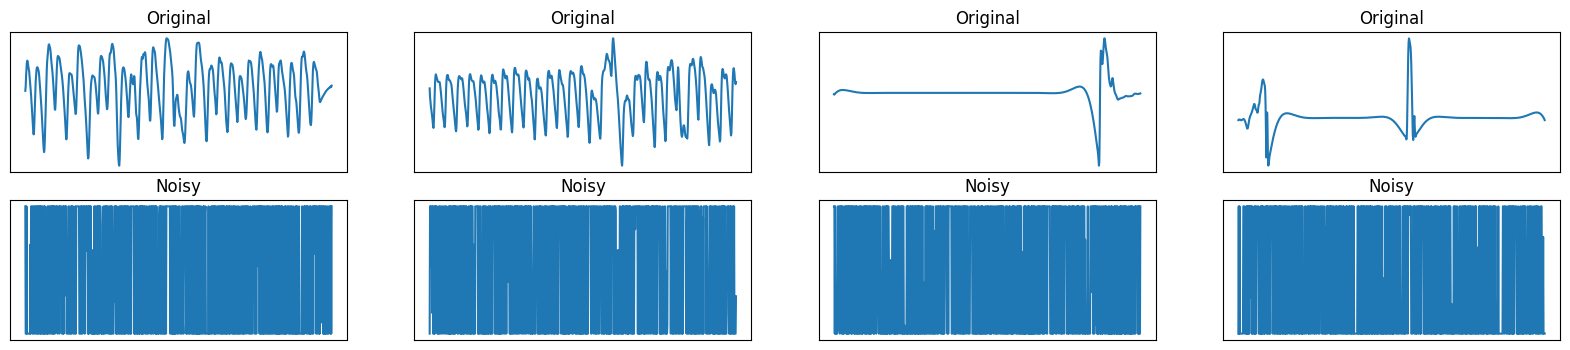

In [4]:
# Create a copy of the data with added noise
noise_levels = [0.001, 0.25, 0.5, 0.75, 1, 2, 5]
noisy_train_data = []
noisy_test_data = []
for noise_factor in noise_levels:
    noisy_train_data.append(noise(train_data, noise_factor = noise_factor))
    noisy_test_data.append(noise(test_data, noise_factor = noise_factor))

# Display the train data with added noise
for i in range(len(noise_levels)):
    print(f"Noise Factor: {noise_levels[i]}")
    display(train_data, noisy_train_data[i])

# Comcatenate all noisy images to become a whole dataset
simulated_noisy_train_data = np.concatenate(noisy_train_data, axis=0)
simulated_noisy_test_data = np.concatenate(noisy_test_data, axis=0)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

[See Supplementary Table 3 for CDAE Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

In [5]:
# Input Layer
input_layer = layers.Input(shape=(800, 1)) 

# Encoder
# Kernel_size is calculated as following:
# params = (kernel_size * input_channels + 1) * filters
x = layers.Conv1D(filters=64, kernel_size = 10, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=45, kernel_size = 8, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=50, kernel_size=5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=2)(x)  

# Decoder
x = layers.Conv1D(filters=50, kernel_size=5, activation='relu', padding='same')(x)
x = layers.UpSampling1D(size=2)(x) 
x = layers.Conv1D(filters=45, kernel_size = 8, activation='relu', padding='same')(x)
x = layers.UpSampling1D(size=3)(x)  
x = layers.Conv1D(filters=64, kernel_size = 10, activation='relu', padding='same')(x)
x = layers.UpSampling1D(size=3)(x)  

# Flatten
x = layers.Flatten()(x)  # (None, 792, 64) -> (None, 792 * 64) = (None, 50688)

# Dense
x = layers.Dense(units=800, activation='relu')(x)  # (None, 50688) -> (None, 800)

# Reshape to match input shape
x = layers.Reshape((800, 1))(x)  # (None, 800) -> (None, 800, 1)

# Build CDAE model
cdae = Model(inputs=input_layer, outputs=x)
cdae.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
cdae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 800, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 266, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 266, 45)        │        23,085 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 88, 45)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 88, 50)         │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 44, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 50)         │        12,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 88, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 88, 45)         │        18,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 264, 45)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 264, 64)        │        28,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 792, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │    40,551,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 800, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,645,748 (155.05 MB)

 Trainable params: 40,645,748 (155.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train CDAE

Now we can train our autoencoder using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images. Notice we are setting up the validation data using the same
format.

In [6]:
print("simulated_noisy_train_data shape:", simulated_noisy_train_data.shape)
print("train_data shape before tiling:", train_data.shape)
print("y shape after tiling:", np.tile(train_data, (len(noise_levels), 1, 1)).shape)

simulated_noisy_train_data shape: (7000, 800, 1)
train_data shape before tiling: (1000, 800, 1)
y shape after tiling: (7000, 800, 1)


In [7]:
# Initial learning rate
initial_lr = 0.01

def lr_schedule(epoch, lr):
    if epoch % 25 == 0 and epoch > 0:
        return max(lr - 0.001, 0.0001)  # Make sure the learning rate does not become negative
    return lr

lr_reduction = LearningRateScheduler(lr_schedule, verbose=1)

# Train Autoencoder
history = cdae.fit(
    # The input to the CDAE was the simulated signal dataset
    # with a Gaussian noise factor of 0.001, 0.5, 0.25, 0.75,
    # 1, 2, and 5 added to corrupt the simulated signals.
    x=simulated_noisy_train_data,

    # The uncorrupted simulated signals are then used as the
    # target for reconstruction.
    y=np.tile(train_data, (len(noise_levels), 1, 1)),
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(simulated_noisy_test_data, np.tile(test_data, (len(noise_levels), 1, 1))),
    callbacks=[lr_reduction]
)

print(history.history) 


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - loss: nan - val_loss: 0.3091 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - loss: nan - val_loss: 0.3091 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: nan - val_loss: 0.3091 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - loss: nan - val_loss: 0.3091 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: nan - val_loss: 0.3091 - learning_rate: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001

Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

## Use CDAE for prediction

Since now I'm only using a very tiny subset of the dataset, it makes sense that the model is performing very badly.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


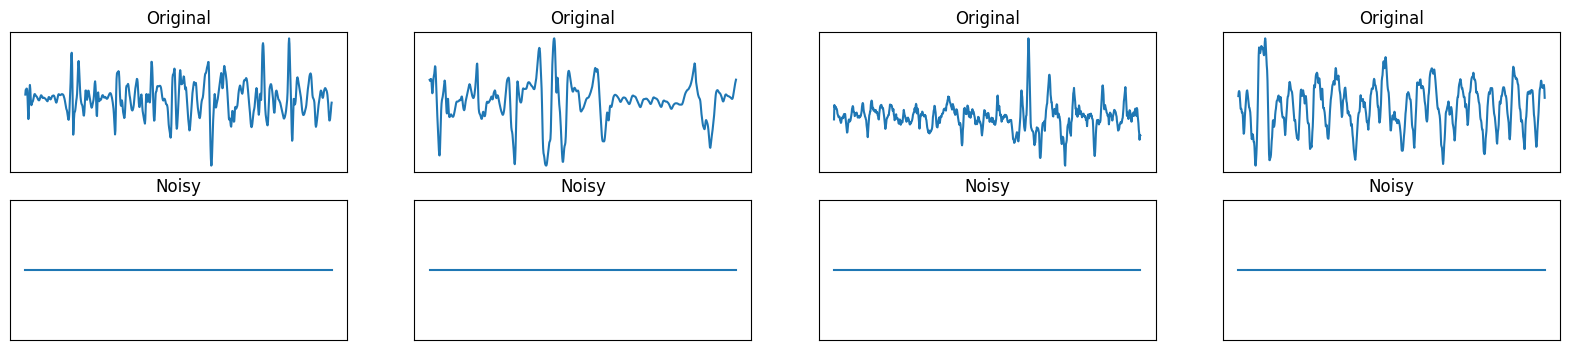

In [8]:
predictions = cdae.predict(test_data)
display(test_data, predictions)

# Transfer Learning

TODO: [See here for tutorial](https://keras.io/guides/transfer_learning/)

The typical transfer-learning workflow
This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights (from pre-trained CDAE as illustrated above) into it.
2. Freeze all layers in the base model by setting <code>trainable = False</code>.
3. Create a new model (DeepBeat Architecture) on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.

# DeepBeat Architecture (Multi-Task Learning)
TODO: Modify the code based on the workflow.

[See Supplementary Table 5 for Model Details](https://static-content.springer.com/esm/art%3A10.1038%2Fs41746-020-00320-4/MediaObjects/41746_2020_320_MOESM1_ESM.pdf)

In [ ]:
# Input Layer
input_layer = layers.Input(shape=(800, 1)) 

# Encoder (Base Model)
x = layers.Conv1D(filters=64, kernel_size = 10, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=45, kernel_size = 8, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=3)(x)  
x = layers.Conv1D(filters=50, kernel_size=5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=2)(x)  

# Freeze layers in base model
# TODO

# DeepBeat Architecture:
# Shared Layers
x = layers.BatchNormalization()(x)

x = layers.Conv1D(filters=64, kernel_size=6, strides = 3, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(filters=35, kernel_size=5, strides = 3, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv1D(filters=64, kernel_size=5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

In [10]:
# Rhythm Branch
rythm = layers.Conv1D(filters=35, kernel_size=2, strides = 3, padding='same')(x)
rythm = layers.BatchNormalization()(rythm)
rythm = layers.Dropout(0.5)(rythm)

rythm = layers.Conv1D(filters=25, kernel_size=2, strides = 3, padding='same')(rythm)
rythm = layers.BatchNormalization()(rythm)
rythm = layers.Dropout(0.5)(rythm)

rythm = layers.Conv1D(filters=35, kernel_size=2, padding='same')(rythm)
rythm = layers.BatchNormalization()(rythm)
rythm = layers.Dropout(0.5)(rythm)

rythm = layers.Flatten()(rythm)
rythm = layers.Dense(175, activation='relu')(rythm)
rythm = layers.Dense(2, activation='softmax')(rythm)

# Build rhythm_branch model
rhythm_branch = Model(inputs=x, outputs=rythm)
rhythm_branch.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
rhythm_branch.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_35CLONE            │ (None, 5, 64)          │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 2, 35)          │         4,515 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 35)          │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1, 25)          │         1,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1, 35)          │         1,785 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1, 35)          │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 175)            │         6,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,107 (59.01 KB)

 Trainable params: 14,917 (58.27 KB)

 Non-trainable params: 190 (760.00 B)

In [11]:
# Quality Assessment Branch
qa = layers.Conv1D(filters=25, kernel_size=3, strides=2, padding='same')(x)
qa = layers.BatchNormalization()(qa)
qa = layers.Dropout(0.5)(qa)
qa = layers.Flatten()(qa)
qa = layers.Dense(175, activation='relu')(qa)
qa = layers.Dense(3, activation='softmax')(qa)

# Build multi-task learning model
qa_branch = Model(inputs=x, outputs=qa)
qa_branch.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
qa_branch.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_35CLONE            │ (None, 5, 64)          │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 25)          │         4,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 175)            │        13,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,753 (73.25 KB)

 Trainable params: 18,703 (73.06 KB)

 Non-trainable params: 50 (200.00 B)

In [12]:
# Build multi-task learning model
multitask = Model(inputs=input_layer, outputs=[rythm, qa])
multitask.compile(optimizer='adam', loss='mean_squared_error')

# Print structure
multitask.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 800, 64)   │        704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 266, 64)   │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 266, 45)   │     23,085 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 88, 45)    │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 88, 50)    │     11,300 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 44, 50)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 44, 50)    │        200 │ max_pooling1d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 15, 64)    │     19,264 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 15, 64)    │          0 │ conv1d_9[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 64)    │        256 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 35)     │     11,235 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 5, 35)     │          0 │ conv1d_10[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 35)     │        140 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 35)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 5, 64)     │     11,264 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 5, 64)     │          0 │ conv1d_11[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64)     │        256 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 111,564 (435.80 KB)

 Trainable params: 110,898 (433.20 KB)

 Non-trainable params: 666 (2.60 KB)